# Using UniaxialExtension

In [1]:
import pymecht as pmt
import numpy as np
from matplotlib import pyplot as plt

The `pymecht.UniaxialExtension` module simulates a specimen made up of any material under uniaxial extension conditino. It can calculate deformation given a force, or force given a deformation. 

In [2]:
pmt.UniaxialExtension?

Init signature:
pmt.UniaxialExtension(
    mat_model,
    disp_measure='stretch',
    force_measure='cauchy',
)
Docstring:     
For simulating uniaxial extension of a sample

+-----------+-----------------------+
| Parameter | Description (default) |
+===========+=======================+
| L0        | Length of sample (1)  |
+-----------+-----------------------+
| A0        | Cross-section area (1)|
+-----------+-----------------------+

Parameters
----------
mat_model: MatModel
    A material model object of type MatModel

disp_measure: str
    The measure of displacement with the following options:
    
    * 'stretch' : The stretch ratio (default)
    * 'strain' : The Green-Lagrange strain
    * 'deltal' : The change in length
    * 'length' : The length
    
force_measure: str
    The measure of force with the following options:

    * 'force' : The force per unit area
    * 'cauchy' : The Cauchy stress (default)
    * '1pk' or '1stpk' or 'firstpk' : The first Piola-Kirchhoff stres

For details about the material options, please refer to the [MatModel module](https://pymecht.readthedocs.io/en/latest/matmodel.html). The default settings for displacement and force are `stretch` and `cauchy` stress respectively. For details about the description of different options in displacement or force, please refer to the [pymecht.SampleExperiment.UniaxialExtension](https://pymecht.readthedocs.io/en/latest/sampleexperiment.html#pymecht.SampleExperiment.UniaxialExtension).

## Displacement controlled

Firstly, we begin by calculating the force given a deformation. The `pymecht.UniaxialExtension` module offers four displacement measurement options: stretch, strain, length, and deltal. The default setting is `disp_measure = 'stretch'`. We can change the displacement measurement setting using the `disp_measure` option. 

For calculating the force measure at a given deformation, we use `pmt.UniaxialExtension.disp_controlled`. 

***pmt.UniaxialExtension.disp_controlled(self, inp, params=None)***

It has two inputs: *inp* and *params*. *inp* represents the given deformation data, *params* represents the parameter values of sample. The process is shown below.

The whole process of simulating uniaxial experiment can be divided into 5 steps: 
1. Define material  
2. Set sample and measurement option  
3. Set parameter values  
4. Give measurements value (force or displacement)  
5. Simulate  

In this example, the material properties are defined as a combination of the Neo-Hookean model and the Gasser-Ogden-Holzapfel model. The displacement measurement option is set to `disp_measure = 'length'`, and the force measurement remains at the default `force_measure = 'force'`. For the uniaxial extension simulation, the fiber direction is set along the extension direction using `pmt.specify_single_fiber`. For more details about fiber direction, please read [Setting fiber directions](https://pymecht.readthedocs.io/en/latest/Examples/matmodel-example.html#Setting-fiber-directions).

In [3]:
#define material
mat = pmt.MatModel('nh', 'goh')

#set sample and measurement option
sample = pmt.UniaxialExtension(mat, disp_measure = 'length')
pmt.specify_single_fiber(sample)

#set parameter values
sample_params = sample.parameters
sample_params.set('mu_0',5)
sample_params.set('A0',0.1)
sample_params.set('L0',1)
sample_params.set('k1_1',5)
sample_params.set('k2_1',15)
sample_params.set('k3_1',0.1)
print(sample)
print(sample_params)

Fiber directions set to  0  degrees ( 0.0  radians)
An object of type UniaxialExtensionwith length as input, cauchy as output, and the following material
Material model with 2 components:
Component1: NH with fiber direction(s):[array([1., 0., 0.])]
Component2: GOH with fiber direction(s):[array([1., 0., 0.])]

------------------------------------------------------------------
Keys              Value       Fixed?      Lower bound Upper bound 
------------------------------------------------------------------
L0                1.00        No          1.00e-04    1.00e+03    
A0                0.10        No          1.00e-04    1.00e+03    
mu_0              5.00        No          1.00e-04    1.00e+02    
k1_1              5.00        No          0.10        30.00       
k2_1              15.00       No          0.10        30.00       
k3_1              0.10        No          0.00        0.33        
------------------------------------------------------------------



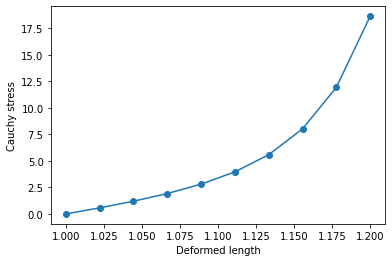

In [4]:
#give applied displacement
deformed_length = np.linspace(1, 1.2, 10)

#calculating force
force = sample.disp_controlled(deformed_length,sample_params)

#post-processing
plt.plot(deformed_length,force,'-o')
plt.ylabel('Cauchy stress')
plt.xlabel('Deformed length')
plt.show()

### Other types of deformation option (`'stretch', 'strain'` and `'deltal'`)

It also offers other displacement measurement options. Following the steps outlined above, examples of these alternative options are provided below. To simplify the code, the displacement values are generated and stored in `label_disp`, which is a dictionary. These values are then used in a loop. The force measurement remains at the default setting of cauchy stress.

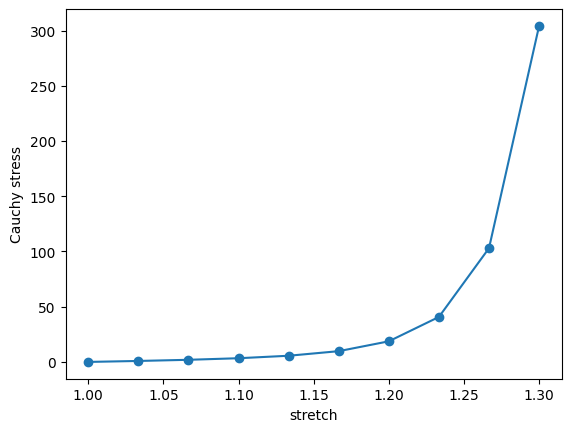

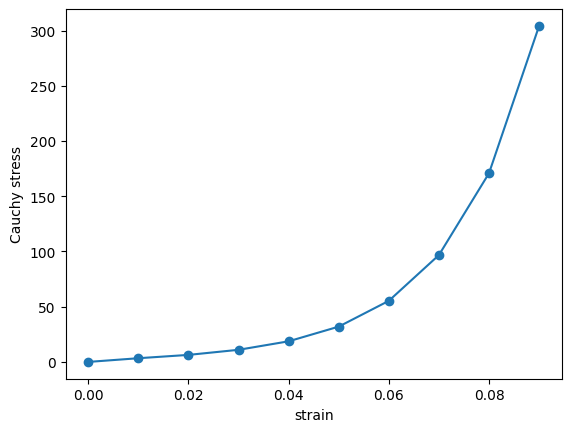

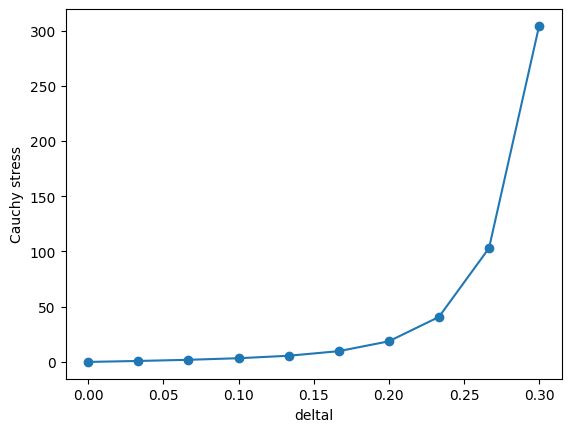

In [ ]:
label_disp = {'stretch': np.linspace(1,1.3,10), 'strain': np.linspace(0,0.09,10),'deltal': np.linspace(0, 0.3,10)} #the different types of disp measurements


for key, value in label_disp.items():
    
    #create the sample and measurement option
    sample = pmt.UniaxialExtension(mat, disp_measure = key )
    
    #given applied displacement
    applied_disp = value #applied displacement
    
    #calculating stress
    stress = sample.disp_controlled(applied_disp, sample_params)
    
    #post-processing
    plt.plot(applied_disp,stress,'-o')
    plt.ylabel('Cauchy stress')
    plt.xlabel(key)
    plt.show()

## Force controlled

Similar to the displacement measurement options, the force measurement in `pymechT` also offers several alternatives. The available options for force measurement are: `force`, `cauchy`: Cauchy stress, `1pk`: 1st PK stress, and `2pk`: 2nd PK stress. We can change the force measurement setting using the `force_measure` option. The first example uses the `force` option, and the displacement measurment is `stretch`. The process is same as the steps as above.

For calculation of force given deformation, we use `pmt.UniaxialExtension.force_controlled`

***pmt.UniaxialExtension.force_controlled(self, forces, params=None, x0=None)***

It has three inputs: *forces*, *params* and *x0*. *forces* represents the given force data, *params* represents the parameter values of sample, *x0* represents the initial guess for the displacement.

When using `force_controlled` simulation, an iterative solution is involved, for which an initial guess is required. There is a default value, which may not be reasonable for different `disp_measure`s. Thus, we explicitly specify the initial guess using `x0` argument.

In [6]:
#define material
mat = pmt.MatModel('nh', 'goh')

#set sample
sample = pmt.UniaxialExtension(mat, force_measure='force')
pmt.specify_single_fiber(sample)

#set parameter value
sample_params = sample.parameters
sample_params.set('mu_0',5)
sample_params.set('A0',0.1)
sample_params.set('L0',10)
sample_params.set('k1_1',5)
sample_params.set('k2_1',15)
sample_params.set('k3_1',0.1)
print(sample)
print(sample_params)

Fiber directions set to  0  degrees ( 0.0  radians)
An object of type UniaxialExtensionwith stretch as input, force as output, and the following material
Material model with 2 components:
Component1: NH with fiber direction(s):[array([1., 0., 0.])]
Component2: GOH with fiber direction(s):[array([1., 0., 0.])]

------------------------------------------------------------------
Keys              Value       Fixed?      Lower bound Upper bound 
------------------------------------------------------------------
L0                10.00       No          1.00e-04    1.00e+03    
A0                0.10        No          1.00e-04    1.00e+03    
mu_0              5.00        No          1.00e-04    1.00e+02    
k1_1              5.00        No          0.10        30.00       
k2_1              15.00       No          0.10        30.00       
k3_1              0.10        No          0.00        0.33        
------------------------------------------------------------------



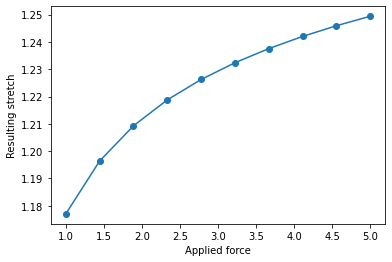

In [7]:
#apply force
applied_force = np.linspace(1,5,10)

#calculating deformation
deformation = sample.force_controlled(applied_force, sample_params, x0 = [0.1])

#post-processing
plt.plot(applied_force,deformation,'-o')
plt.ylabel('Resulting stretch')
plt.xlabel('Applied force')
plt.show()

## Different `force_measure`s

The other options for `force_measure` are demonstrated below.

Fiber directions set to  0  degrees ( 0.0  radians)


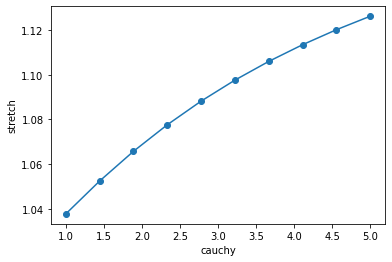

Fiber directions set to  0  degrees ( 0.0  radians)


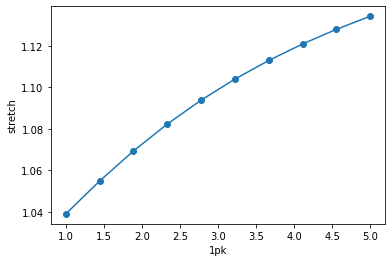

Fiber directions set to  0  degrees ( 0.0  radians)


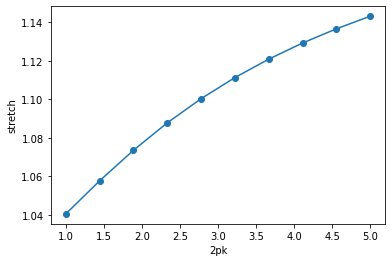

In [8]:
#define material
mat = pmt.MatModel('nh', 'goh')

label_force = {'cauchy': np.linspace(1,5,10), '1pk': np.linspace(1,5,10),'2pk': np.linspace(1,5,10)} #different types of force measurements used in for loop

for key, value in label_force.items():
    sample = pmt.UniaxialExtension(mat, force_measure = key )   
    pmt.specify_single_fiber(sample)

    #force setting
    applied_force = value
    
    #calculating deformation (strech)
    disp = sample.force_controlled(applied_force, sample_params, x0 = [0.5])
    
    #post-process
    plt.plot(applied_force,disp,'-o')
    plt.ylabel('stretch')
    plt.xlabel(key)
    plt.show()

## Combining different `'disp_measure'` and `'force_measure'`

One can also freely combine different options for `disp_measure` and `force_measure`. For example, we used `disp_measure = 'strain'` and `force_measure = 'cauchy'`.

Fiber directions set to  0  degrees ( 0.0  radians)


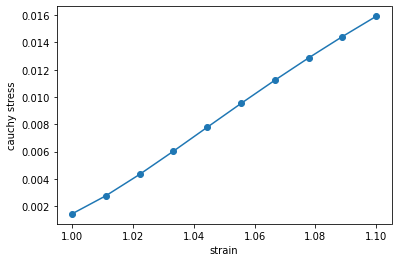

In [9]:
#define material
mat = pmt.MatModel('nh', 'goh')

#set sample
sample = pmt.UniaxialExtension(mat, disp_measure = 'strain ', force_measure = 'cauchy' )
sample_params = sample.parameters
pmt.specify_single_fiber(sample)

#set parameter
sample_params.set('mu_0',5)
sample_params.set('A0',0.1)
sample_params.set('L0',10)
sample_params.set('k1_1',5)
sample_params.set('k2_1',15)
sample_params.set('k3_1',0.1)

#calculating displacement (force)
applied_strain = np.linspace(1,1.1,10)

#calculating force (displacement)
cauchy = sample.force_controlled(applied_force, sample_params, x0 = None)

#post-process
plt.plot(applied_strain,cauchy,'-o')
plt.ylabel('cauchy stress')
plt.xlabel('strain')
plt.show()

## Fiber direction warning

We use `[1, 0, 0]` as a single fibre direction via `pmt.specify_single_fiber` in this example. One can manually specify fiber direction in the material models before using them to create a UniaxialExtension sample, as follows.

In [10]:
mat = pmt.MatModel('goh','nh')
mat_models = mat.models
mat_models[0].fiber_dirs = np.array([1,0,0])
sample = pmt.UniaxialExtension(mat)

However, the `UniaxialExtension` assumes that fibers are aligned along the first direction such that the material is transversely isotropic. If this assumption is not satisfied, it can result in erroneous results. Thus, in such situations, a warning will be generated.

In [11]:
mat = pmt.MatModel('goh','nh')
mat_models = mat.models
mat_models[0].fiber_dirs = np.array([1,1,0])
sample = pmt.UniaxialExtension(mat)

/usr/local/lib/python3.9/site-packages/pymecht/SampleExperiment.py:314: UserWarning: The UniaxialExtension assumes that fibers are aligned along the first direction. This is not satisfied and the results may be spurious.
  warnings.warn("The UniaxialExtension assumes that fibers are aligned along the first direction. This is not satisfied and the results may be spurious.")
